In [1]:
# use dream_proj_env conda environment
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, ttest_ind, mannwhitneyu,linregress,ttest_ind_from_stats
import glob
import gseapy 
import scanpy as sc
from pybiomart import Dataset
import random
from pylr2 import regress2
import statsmodels.api as sm
import statsmodels.formula.api as smf
import colorcet as cc
import psynlig
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# auto reload source files
%load_ext autoreload
%autoreload 2
# add source directory to path
source_path = os.path.abspath(os.path.join('..'))
if source_path not in sys.path:
    sys.path.append(os.path.join(source_path, 'source'))
# read source files–––
import read_data
from expr_dataset import ExpressionDataset
from meta_expr_dataset import MetaExpressionDataset
import utils
# colorpalettes 
hmm = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
fred_again_again_again_palette = ['#000305', '#ff7758', '#f67805', '#d3d3d3', '#565656', '#054fff', '#f9aa74', '#5890ff']
sunset = ['#f3e79b','#fac484','#f8a07e','#eb7f86','#ce6693','#a059a0','#5c53a5']
my_continous_palette = sunset
my_categorical_palette = []
my_categorical_palette.append(hmm[3])
my_categorical_palette.append(fred_again_again_again_palette[-2])
my_categorical_palette.append(hmm[-1])
my_categorical_palette.append(fred_again_again_again_palette[-1])

my_categorical_palette.append(hmm[2])
my_categorical_palette.append(sunset[-1])
my_categorical_palette.append(sunset[-2])
my_categorical_palette.append(sunset[-5])
my_categorical_palette.append(sunset[-7])

%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
"""sns.set_theme(style='white')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True"""
# create mapping of Organ to color
organ_palette = {
    "Liver": my_categorical_palette[1],
    "Kidney": my_categorical_palette[2],
    "Brain": my_categorical_palette[5],
}


In [ ]:
import os
# repo root for relative paths
REPO_ROOT = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))

# Read in synapse datasets

In [2]:
loader = read_data.DatasetLoader("synapse_rna_seq_harmonization")
harmonization = loader.load_dataset()
harmonization.calc_total_seq_depth()
harmonization.get_dream_gene_expression()
harmonization.dream_enrichment_ssgsea()
harmonization.scale_dream_by_seq_depth(
    'DREAM_normalized_enrichment_score',
    eq='DREAM_normalized_enrichment_score ~ total_seq_depth * n_genes_expressed'
    )

# rescale DREAM_normalized_enrichment_score_resid to be between 0 and 1
harmonization.dream_expression['DREAM_normalized_enrichment_score_resid'] = (harmonization.dream_expression['DREAM_normalized_enrichment_score_resid'] - min(harmonization.dream_expression['DREAM_normalized_enrichment_score_resid'])) / (max(harmonization.dream_expression['DREAM_normalized_enrichment_score_resid']) - min(harmonization.dream_expression['DREAM_normalized_enrichment_score_resid']))

print(f"Number of individuals with bulk rna-seq: {harmonization.dream_expression['individualID'].nunique()}, samples per individual: {harmonization.dream_expression['individualID'].value_counts().mean()}")

Loading dataset: synapse_rna_seq_harmonization


/cellar/users/zkoch/dream/source/expr_dataset.py:758: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  self.expression_df = self.expression_df.groupby(


using new dream file:  False
Read in 328 DREAM genes
Did not need to convert DREAM genes
Found 322 DREAM genes with expression
scaled mean_dream_reg_expr by sequence depth and created mean_dream_reg_expr_resid
using new dream file:  False


2025-03-06 09:23:45,947 [INFO] Parsing data files for ssGSEA...........................
2025-03-06 09:24:03,536 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-03-06 09:24:03,540 [INFO] 0001 gene_sets used for further statistical testing.....
2025-03-06 09:24:03,540 [INFO] Start to run ssGSEA...Might take a while................


scaled DREAM_normalized_enrichment_score by sequence depth and created DREAM_normalized_enrichment_score_resid
scaled DREAM_enrichment_score by sequence depth and created DREAM_enrichment_score_resid
scaled DREAM_normalized_enrichment_score by sequence depth and created DREAM_normalized_enrichment_score_resid
Number of individuals with bulk rna-seq: 1168, samples per individual: 2.4032534246575343


In [3]:
loader = read_data.DatasetLoader("synapse_MIT_ROSMAP_Multiomics_10x")
sc_rosmap_10x = loader.load_dataset()

print(f"Number of individuals with 10x: {sc_rosmap_10x.dream_expression.obs['individualID'].nunique()}, cells per individual: {sc_rosmap_10x.dream_expression.obs['individualID'].value_counts().mean()}")

Loading dataset: synapse_MIT_ROSMAP_Multiomics_10x
loading synapse_MIT_ROSMAP_Multiomics_10x from pickle


Number of individuals with 10x: 404, cells per individual: 5903.5767326732675


/cellar/users/zkoch/dream/source/read_data.py:726: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  synapse.dream_expression.obs['age_first_ad_dx'] = synapse.dream_expression.obs['age_first_ad_dx'].replace('90+',90).astype(float)
/cellar/users/zkoch/dream/source/read_data.py:727: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  synapse.dream_expression.obs['age_death'] = synapse.dream_expression.obs['age_death'].replace('90+',90).astype(float)
/cellar/users/zkoch/dream/source/read_data.py:728: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with Ca

In [4]:
loader = read_data.DatasetLoader("synapse_MIT_ROSMAP_Multiomics_smartseq")
sc_rosmap_smart = loader.load_dataset()
sc_rosmap_smart.scale_dream_by_seq_depth(
    'DREAM_normalized_enrichment_score',
    eq='DREAM_normalized_enrichment_score ~ 1'
    )

print(f"Number of individuals with smartseq: {sc_rosmap_smart.dream_expression.obs['individualID'].nunique()}, cells per individual: {sc_rosmap_smart.dream_expression.obs['individualID'].value_counts().mean()}")

Loading dataset: synapse_MIT_ROSMAP_Multiomics_smartseq
scaled DREAM_normalized_enrichment_score by sequence depth and created DREAM_normalized_enrichment_score_resid
Number of individuals with smartseq: 47, cells per individual: 117.65957446808511


In [ ]:
methyl.to_parquet(os.path.join(REPO_ROOT, 'data/synapse_ROSMAP_methylation/ROSMAP_arrayMethylation_imputed_transposed.parquet'))

# Age of diagnosis vs. DREAM

### RNA-seq harmonization

In [16]:
# create survival df
survival_df_harmonization = harmonization.dream_expression[harmonization.dream_expression.columns[-45:]].copy(deep=True)
# create event column
survival_df_harmonization['ad_case'] = (survival_df_harmonization['dcfdx_lv'] == 4) | (survival_df_harmonization['dcfdx_lv'] == 5)
# create censor column at 90 years
survival_df_harmonization['censor'] = survival_df_harmonization['ad_case'] & (survival_df_harmonization['age_death'] < 90)
# within each tissue, z-score DREAM_normalized_enrichment_score_resid
for tissue in survival_df_harmonization['tissue'].unique():
    survival_df_harmonization.loc[
        survival_df_harmonization['tissue'] == tissue, 'DREAM z-score'
        ] = (
            survival_df_harmonization.loc[survival_df_harmonization['tissue'] == tissue, 'DREAM_normalized_enrichment_score_resid'] - survival_df_harmonization.loc[survival_df_harmonization['tissue'] == tissue, 'DREAM_normalized_enrichment_score_resid'].mean()
            ) \
            / survival_df_harmonization.loc[survival_df_harmonization['tissue'] == tissue, 'DREAM_normalized_enrichment_score_resid'].std()
survival_df_harmonization['z_DREAM_normalized_enrichment_score_resid'] = survival_df_harmonization['DREAM z-score']

# drop rows where ad_case == False and age_first_ad_dx is not null
survival_df_harmonization.query("ad_case == True | age_first_ad_dx.isna()", inplace = True)
# create time column from age_first_ad_dx and age_death
survival_df_harmonization['age_diagnosis'] = np.where(
    survival_df_harmonization['age_first_ad_dx'].isna(),
    survival_df_harmonization['age_death'],
    survival_df_harmonization['age_first_ad_dx'])

survival_df_harmonization.dropna(subset = ['age_diagnosis', 'ad_case'], inplace = True)

def count_apoe_4_alleles(x):
    # convert to string
    x = str(x)
    # count the number of apoe 4 alleles
    return x.count('4')
# count the number of apoe 4 alleles
survival_df_harmonization['num_apoe_4_alleles'] = survival_df_harmonization['apoe_genotype'].apply(count_apoe_4_alleles)

In [ ]:
# read in random background
background_fns = glob.glob(os.path.join(REPO_ROOT, 'data/synapse_rna_seq_harmonization/random_background/*parquet'))
background_dfs = []
for background_fn in background_fns:
    background_df = pd.read_parquet(background_fn)
    background_dfs.append(background_df)
all_background_df = pd.concat(background_dfs)

# merge with survival df
survival_df_harmonization = survival_df_harmonization.merge(all_background_df, left_index = True, right_index = True, how = 'left')

# z-score each random column within each tissue
for tissue in survival_df_harmonization['tissue'].unique():
    survival_df_harmonization.loc[survival_df_harmonization['tissue'] == tissue, all_background_df.columns] = (survival_df_harmonization.loc[survival_df_harmonization['tissue'] == tissue, all_background_df.columns] - survival_df_harmonization.loc[survival_df_harmonization['tissue'] == tissue, all_background_df.columns].mean()) / survival_df_harmonization.loc[survival_df_harmonization['tissue'] == tissue, all_background_df.columns].std()


In [257]:
# read in cell cycle random background
cc_background_fns = glob.glob(os.path.join(REPO_ROOT, 'data/synapse_rna_seq_harmonization/cell_cycle_random_background/*parquet'))
cc_background_dfs = []
for background_fn in cc_background_fns:
    background_df = pd.read_parquet(background_fn)
    cc_background_dfs.append(background_df)
cc_background_df = pd.concat(cc_background_dfs)
# add cc to beginning of column names
cc_background_df.columns = ['CC' + col for col in cc_background_df.columns]
# merge with survival df
survival_df_harmonization = survival_df_harmonization.merge(cc_background_df, left_index = True, right_index = True, how = 'left')

# z-score each random column within each tissue
for tissue in survival_df_harmonization['tissue'].unique():
    survival_df_harmonization.loc[survival_df_harmonization['tissue'] == tissue, cc_background_df.columns] = (survival_df_harmonization.loc[survival_df_harmonization['tissue'] == tissue, cc_background_df.columns] - survival_df_harmonization.loc[survival_df_harmonization['tissue'] == tissue, cc_background_df.columns].mean()) / survival_df_harmonization.loc[survival_df_harmonization['tissue'] == tissue, cc_background_df.columns].std()

### f) Kaplan meier

/tmp/ipykernel_2124644/3195337256.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df['dream_bin'] = pd.qcut(survival_df['z_DREAM_normalized_enrichment_score_resid'], q = len(bins_to_calc), labels = bins_to_calc)


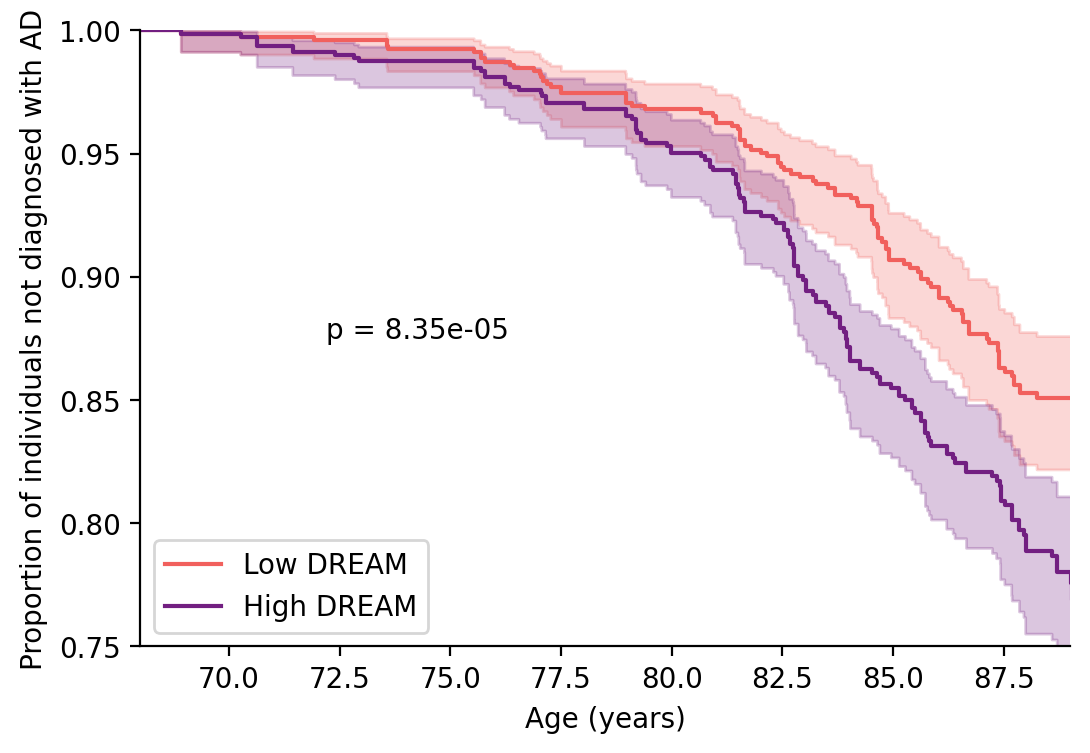

In [5]:
def plot_kmf(survival_df, dream_bin_col = 'dream_bin', bins_to_calc = ['low','medium', 'high'], bins_to_plot = ['low', 'high'], tissue_to_use = '', axes = None):
    if axes is None:
        fig, axes = plt.subplots(1, 1, figsize = (6, 4))
    if tissue_to_use != '':
        survival_df = survival_df.query(f"tissue == '{tissue_to_use}'")
    else:
        tissue_to_use = 'All'
    
    # bin the dream score
    survival_df['dream_bin'] = pd.qcut(survival_df['z_DREAM_normalized_enrichment_score_resid'], q = len(bins_to_calc), labels = bins_to_calc)
        
    # create a categorical palette
    magma_categorical_palette = sns.color_palette('magma_r', len(bins_to_plot))
        
    kmf = KaplanMeierFitter()
    for i, dream_bin in enumerate(bins_to_plot):
        kmf.fit(durations = survival_df.query(f"{dream_bin_col} == '{dream_bin}'")['age_diagnosis'], event_observed = survival_df.query(f"{dream_bin_col} == '{dream_bin}'")['censor'])
        kmf.plot(ax = axes, ci_show = True, label = dream_bin, color = magma_categorical_palette[i])
    axes.legend()
    axes.set_xlim(68, 89)
    axes.set_ylim(.75, 1)
    axes.set_xlabel(f'Age (years)')
    axes.set_ylabel('Proportion of individuals not diagnosed with AD')
    sns.despine(ax = axes)
    
    # do a logrank test and add results to the plot
    results = logrank_test(
        durations_A = survival_df.query(f"{dream_bin_col} == '{bins_to_plot[0]}'")['age_diagnosis'],
        durations_B = survival_df.query(f"{dream_bin_col} == '{bins_to_plot[-1]}'")['age_diagnosis'],
        event_observed_A = survival_df.query(f"{dream_bin_col} == '{bins_to_plot[0]}'")['censor'],
        event_observed_B = survival_df.query(f"{dream_bin_col} == '{bins_to_plot[-1]}'")['censor']
    )
    axes.text(0.2, .5, f"p = {results.p_value:.2e}", transform=axes.transAxes)
    return axes

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
plot_kmf(survival_df_harmonization.query("age_death < 100 and exclude != True and tissue != 'temporal cortex' and tissue != 'frontal cortex'"), dream_bin_col = 'dream_bin', bins_to_calc = ['Low DREAM', 'Medium DREAM', 'High DREAM'], bins_to_plot = ['Low DREAM', 'High DREAM'], axes = ax)

# save as svg
fig.savefig(os.path.join(REPO_ROOT, 'figures/fig_human_mut/kaplan_ad_diagnosis.svg'), bbox_inches = 'tight')

### g) cox

In [14]:
survival_df_harmonization.query("exclude != True and z_DREAM_normalized_enrichment_score_resid < 5 and z_DREAM_normalized_enrichment_score_resid > -5").shape

(2629, 51)

In [15]:
survival_df_harmonization.query("exclude != True").shape

(2632, 51)

In [13]:
survival_df_harmonization.query("exclude != True and z_DREAM_normalized_enrichment_score_resid < 5 and z_DREAM_normalized_enrichment_score_resid > -5")['individualID'].nunique()

1105

In [12]:
survival_df_harmonization['tissue'].value_counts().index

Index(['dorsolateral prefrontal cortex', 'Head of caudate nucleus',
       'posterior cingulate cortex', 'temporal cortex', 'frontal cortex'],
      dtype='object', name='tissue')

In [7]:
survival_df_harmonization.query("exclude != True and z_DREAM_normalized_enrichment_score_resid < 5 and z_DREAM_normalized_enrichment_score_resid > -5")['individualID'].value_counts().describe()

count    1105.000000
mean        2.379186
std         1.009072
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: count, dtype: float64

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 6
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
         145.79 <0.005     93.75


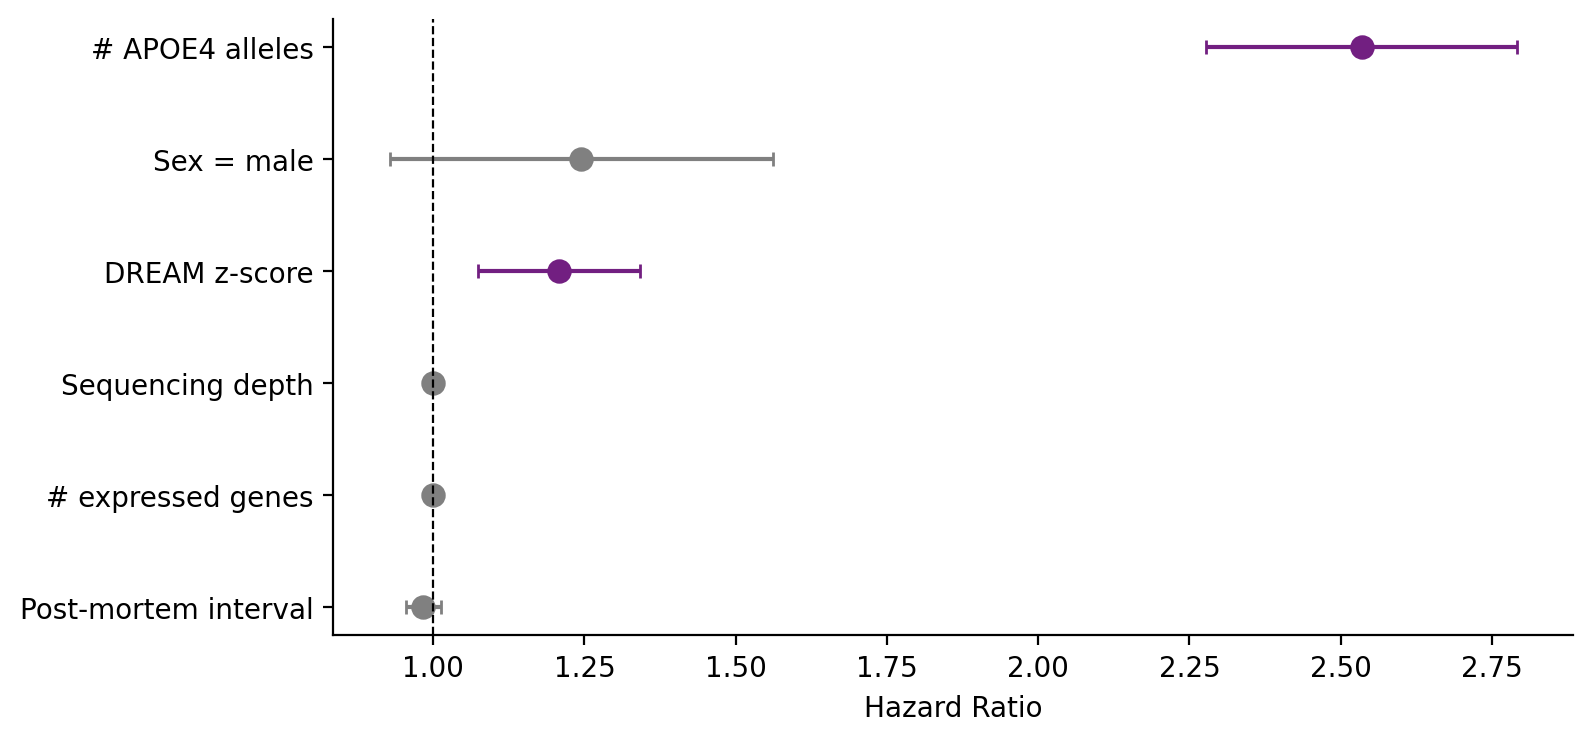

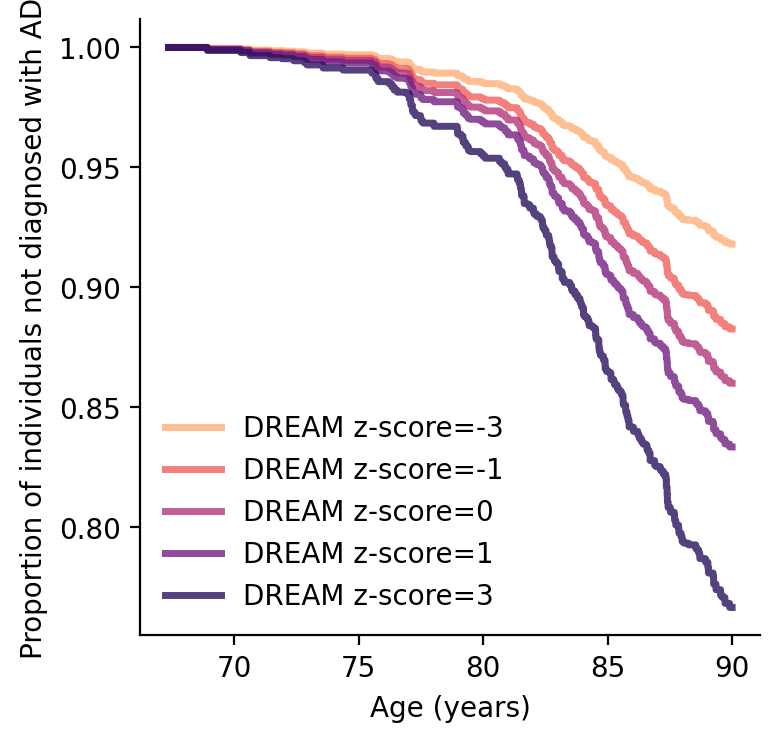

In [6]:
# fit a cox proportional hazards model
survival_df_harmonization.dropna(subset = ['pmi'], inplace = True)
cph = CoxPHFitter()
dream_col = 'DREAM z-score'
cph.fit(
    survival_df_harmonization.query("exclude != True and z_DREAM_normalized_enrichment_score_resid < 5 and z_DREAM_normalized_enrichment_score_resid > -5"),
    duration_col = 'age_diagnosis', event_col = 'censor', cluster_col = 'individualID', #strata = 'tissue',
    formula = f'msex +  n_genes_expressed + total_seq_depth + num_apoe_4_alleles + `{dream_col}` + pmi'
    )
# get hazard ratios
hr_df = cph.summary.reset_index()
hr_df.rename(columns = {'exp(coef)': 'HR', 'exp(coef) lower 95%': 'HR lower 95%', 'exp(coef) upper 95%': 'HR upper 95%'}, inplace = True)
hr_df['sig'] = hr_df['p'] < 0.01
hr_df.sort_values(by = 'HR', ascending = False, inplace = True)
hr_df['covariate'] = hr_df['covariate'].map({
    'msex': 'Sex = male',
    'n_genes_expressed': '# expressed genes',
    'total_seq_depth': 'Sequencing depth',
    'num_apoe_4_alleles': '# APOE4 alleles',
    f'{dream_col}': f'{dream_col}',
    'pmi': 'Post-mortem interval',
})
# plot as a forest plot
fig, ax = plt.subplots(1, 1, figsize = (8, 4))
# create a categorical palette
magma_categorical_palette = sns.color_palette('magma_r', 5)
# Create the plot
sns.pointplot(
    x="HR", y="covariate", data=hr_df,
    linestyle='none',  hue = 'sig', palette = ['grey', magma_categorical_palette[3]],
    legend = False, ax = ax,
    )

# Add error bars manually, with caps
for index, row in hr_df.iterrows():
    if row['sig']:
        ax.errorbar(x=row['HR'], y=row['covariate'], xerr=1.96*row['se(coef)'], fmt='none', ecolor=magma_categorical_palette[3], capsize=2.5)
    else :
        ax.errorbar(x=row['HR'], y=row['covariate'], xerr=1.96*row['se(coef)'], fmt='none', ecolor='grey', capsize=2.5)

# create vertical line at 1
ax.axvline(1, color='black', linestyle='--', linewidth = 0.8)
sns.despine(ax = ax)
ax.set_xlabel('Hazard Ratio')
ax.set_ylabel('')
fig.savefig(os.path.join(REPO_ROOT, 'figures/fig_human_mut/hr_forest_ad_diagnosis.svg'), bbox_inches = 'tight')

print(cph.log_likelihood_ratio_test())

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
# convert to cmap
from matplotlib import colors as mcolors
magma_cmap = mcolors.ListedColormap(magma_categorical_palette)
# get the 10th, 50th, and 90th percentiles of the dream score
# plot survival curves stratified by dream
cph.plot_partial_effects_on_outcome(
    covariates = f'{dream_col}', values = [-3,-1,0,1,3], cmap = magma_cmap,  ax = ax, plot_baseline = False,
    linewidth = 2.5, alpha = 0.8
    )
sns.despine(ax = ax)
# remove box from legend
ax.legend_.set_frame_on(False)
ax.set_xlabel('Age (years)')
ax.set_ylabel('Proportion of individuals not diagnosed with AD')
fig.savefig(os.path.join(REPO_ROOT, 'figures/fig_human_mut/partial_effects_dream.svg'), bbox_inches = 'tight')


In [46]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2620 total observations, 2188 right-censored observations>
             duration col = 'age_diagnosis'
                event col = 'censor'
              cluster col = 'individualID'
          robust variance = True
      baseline estimation = breslow
   number of observations = 2620
number of events observed = 432
   partial log-likelihood = -3203.57
         time fit was run = 2024-11-21 22:19:49 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
msex                0.22      1.24      0.16           -0.10            0.54                0.91                1.71
n_genes_expressed  -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
total_seq_depth     0.00      1.00      0.00            0.00            0.00                1.00                1.00
num_apoe_4_alleles  0.93      2.53      0.13            0.67            1.19                1.96                3.28
DREAM z-score       0.19      1.21      0.07            0.05            0.32                1.06                1.38
pmi                -0.02      0.98      0.01           -0.05            0.01                0.96                1.01

                    cmp to     z      p  -log2(p)
covariate                                        
msex                  0.00  1.35   0.18      2.51
n_genes_expressed     0.00 -0.33   0.74      0.43
total_seq_depth       0.00  2.00   0.05      4.47
num_apoe_4_alleles    0.00  7.10 <0.005     39.53
DREAM z-score         0.00  2.76   0.01      7.42
pmi                   0.00 -1.13   0.26      1.96
---
Concordance = 0.67
Partial AIC = 6419.14
log-likelihood ratio test = 145.79 on 6 df
-log2(p) of ll-ratio test = 93.75

# Supplementary

##### all genes

In [ ]:
df = survival_df_harmonization.query("exclude != True and z_DREAM_normalized_enrichment_score_resid < 5 and z_DREAM_normalized_enrichment_score_resid > -5")

hr_dfs = []
for i, background_col in enumerate(['DREAM z-score'] + all_background_df.columns.tolist()):
    cph = CoxPHFitter()
    cph.fit(
        df,
        duration_col = 'age_diagnosis', event_col = 'censor', cluster_col = 'individualID', #strata = 'tissue',
        formula = f'msex +  n_genes_expressed + total_seq_depth + num_apoe_4_alleles + `{background_col}` + pmi'
    )
    hr_df = cph.summary.reset_index()
    hr_df['var'] = background_col
    hr_dfs.append(hr_df)
    if i % 10 == 0:
        print(f"done {i/len(all_background_df.columns)}")
hr_df = pd.concat(hr_dfs)
hr_df.rename(columns = {'exp(coef)': 'HR', 'exp(coef) lower 95%': 'HR lower 95%', 'exp(coef) upper 95%': 'HR upper 95%'}, inplace = True)
hr_df['sig'] = hr_df['p'] < 0.01
# save to parquet
hr_df.to_parquet(os.path.join(REPO_ROOT, 'data/synapse_rna_seq_harmonization/random_background/all_genes_hr.parquet'))

In [21]:
hr_df = pd.read_parquet(os.path.join(REPO_ROOT, 'data/synapse_rna_seq_harmonization/random_background/all_genes_hr.parquet'))

In [23]:
# find rows where covariate starts with random
random_rows = hr_df['covariate'].str.startswith('random')
# remove everything after the _ in the covariate columns which are the random background columns
hr_df.loc[random_rows, 'covariate'] = hr_df.loc[random_rows, 'covariate'].str.split('_').str[0]

random_rows = hr_df['var'].str.startswith('random')
hr_df.loc[random_rows, 'var'] = hr_df.loc[random_rows, 'var'].str.split('_').str[0]

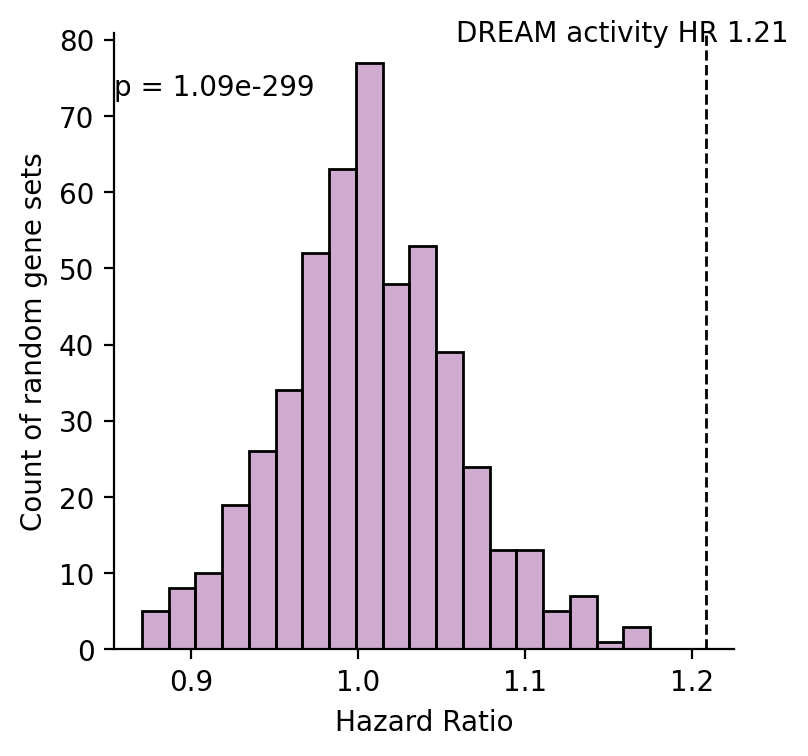

In [24]:
dream_hr = hr_df.query("var == 'DREAM z-score' and covariate == 'DREAM z-score'")['HR'].values[0]
rand = hr_df.query("var == 'random' and covariate == 'random'")['HR'].values

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
sns.histplot(hr_df.query("var == 'random' and covariate == 'random'"), x = 'HR', fill = True, common_norm = False, alpha = 0.5, ax = ax, color = my_categorical_palette[6])
# draw vertical line at dream hr
ax.axvline(dream_hr, color = 'black', linestyle = '--', linewidth = 1)
# label the dream hr
ax.text(dream_hr-.05, ax.get_ylim()[1], f"DREAM activity HR {dream_hr:.2f}", color = 'black', ha = 'center', va = 'center')
sns.despine(ax = ax)
ax.set_xlabel('Hazard Ratio')
ax.set_ylabel('Count of random gene sets')

# test if the mean of rand is different from dream
from scipy import stats
p = stats.ttest_1samp(rand, dream_hr).pvalue
# add p value to plot
ax.text(0, 0.9, f"p = {p:.2e}", transform=ax.transAxes)
fig.savefig(os.path.join(REPO_ROOT, 'figures/supplementary/human_mut/random_genes_hr_distribution.svg'), bbox_inches = 'tight')

##### cell cycle genes

In [ ]:
df = survival_df_harmonization.query("exclude != True and z_DREAM_normalized_enrichment_score_resid < 5 and z_DREAM_normalized_enrichment_score_resid > -5")

cc_hr_dfs = []
for i, background_col in enumerate(['DREAM z-score'] + cc_background_df.columns.tolist()):
    cph = CoxPHFitter()
    cph.fit(
        df,
        duration_col = 'age_diagnosis', event_col = 'censor', cluster_col = 'individualID', #strata = 'tissue',
        formula = f'msex +  n_genes_expressed + total_seq_depth + num_apoe_4_alleles + `{background_col}` + pmi'
    )
    cc_hr_df = cph.summary.reset_index()
    cc_hr_df['var'] = background_col
    cc_hr_dfs.append(cc_hr_df)
    if i % 10 == 0:
        print(f"done {i/len(cc_background_df.columns)}")
cc_hr_df = pd.concat(cc_hr_dfs)
cc_hr_df.rename(columns = {'exp(coef)': 'HR', 'exp(coef) lower 95%': 'HR lower 95%', 'exp(coef) upper 95%': 'HR upper 95%'}, inplace = True)
cc_hr_df['sig'] = cc_hr_df['p'] < 0.01

# save to parquet
cc_hr_df.to_parquet(os.path.join(REPO_ROOT, 'data/synapse_rna_seq_harmonization/cell_cycle_random_background/cc_genes_hr.parquet'))

In [25]:
cc_hr_df = pd.read_parquet(os.path.join(REPO_ROOT, 'data/synapse_rna_seq_harmonization/cell_cycle_random_background/cc_genes_hr.parquet'))

In [26]:
# find rows where covariate starts with random
random_rows = cc_hr_df['covariate'].str.startswith('CCrandom')
# remove everything after the _ in the covariate columns which are the random background columns
cc_hr_df.loc[random_rows, 'covariate'] = cc_hr_df.loc[random_rows, 'covariate'].str.split('_').str[0]

random_rows = cc_hr_df['var'].str.startswith('CCrandom')
cc_hr_df.loc[random_rows, 'var'] = cc_hr_df.loc[random_rows, 'var'].str.split('_').str[0]

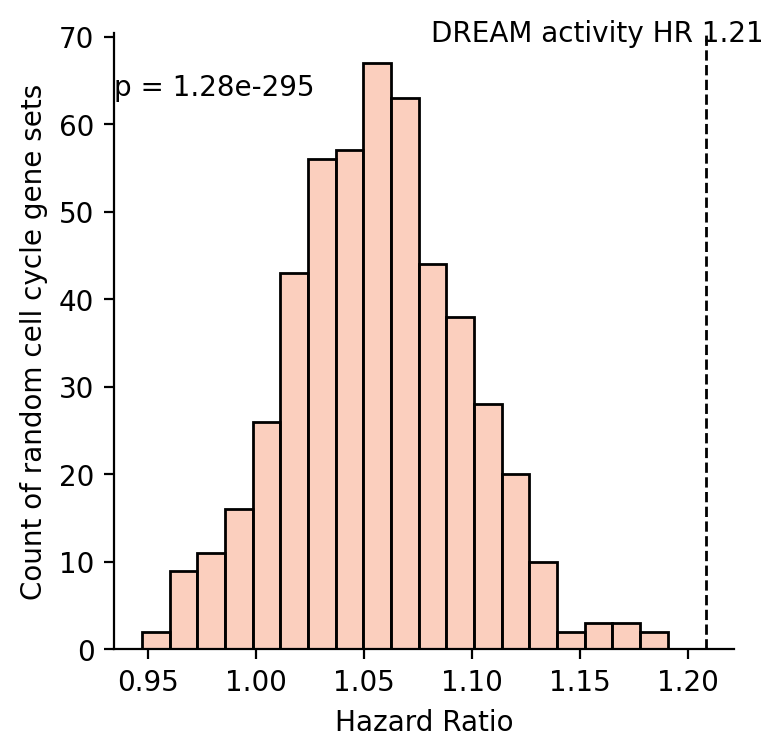

In [27]:
dream_hr = cc_hr_df.query("var == 'DREAM z-score' and covariate == 'DREAM z-score'")['HR'].values[0]
rand = cc_hr_df.query("var == 'CCrandom' and covariate == 'CCrandom'")['HR'].values

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
sns.histplot(cc_hr_df.query("var == 'CCrandom' and covariate == 'CCrandom'"), x = 'HR', fill = True, common_norm = False, alpha = 0.5, ax = ax, color = my_categorical_palette[7])
# draw vertical line at dream hr
ax.axvline(dream_hr, color = 'black', linestyle = '--', linewidth = 1)
# label the dream hr
ax.text(dream_hr-.05, ax.get_ylim()[1], f"DREAM activity HR {dream_hr:.2f}", color = 'black', ha = 'center', va = 'center')
sns.despine(ax = ax)
ax.set_xlabel('Hazard Ratio')
ax.set_ylabel('Count of random cell cycle gene sets')

# test if the mean of rand is different from dream
from scipy import stats
p = stats.ttest_1samp(rand, dream_hr).pvalue
# add p value to plot
ax.text(0, 0.9, f"p = {p:.2e}", transform=ax.transAxes)
fig.savefig(os.path.join(REPO_ROOT, 'figures/supplementary/human_mut/cc_genes_hr_distribution.svg'), bbox_inches = 'tight')

##### Conserved across individuals

frontal cortex_DREAM_normalized_enrichment_score_resid temporal cortex_DREAM_normalized_enrichment_score_resid 4.1743386478790225e-14
frontal cortex_DREAM_normalized_enrichment_score_resid dorsolateral prefrontal cortex_DREAM_normalized_enrichment_score_resid 0.0003487805458296144
frontal cortex_DREAM_normalized_enrichment_score_resid posterior cingulate cortex_DREAM_normalized_enrichment_score_resid 7.152986991629115e-05
frontal cortex_DREAM_normalized_enrichment_score_resid Head of caudate nucleus_DREAM_normalized_enrichment_score_resid 2.429911860741537e-06
temporal cortex_DREAM_normalized_enrichment_score_resid frontal cortex_DREAM_normalized_enrichment_score_resid 4.1743386478790225e-14
temporal cortex_DREAM_normalized_enrichment_score_resid dorsolateral prefrontal cortex_DREAM_normalized_enrichment_score_resid 2.080099304774683e-05
temporal cortex_DREAM_normalized_enrichment_score_resid posterior cingulate cortex_DREAM_normalized_enrichment_score_resid 0.00014021991622467295
temp

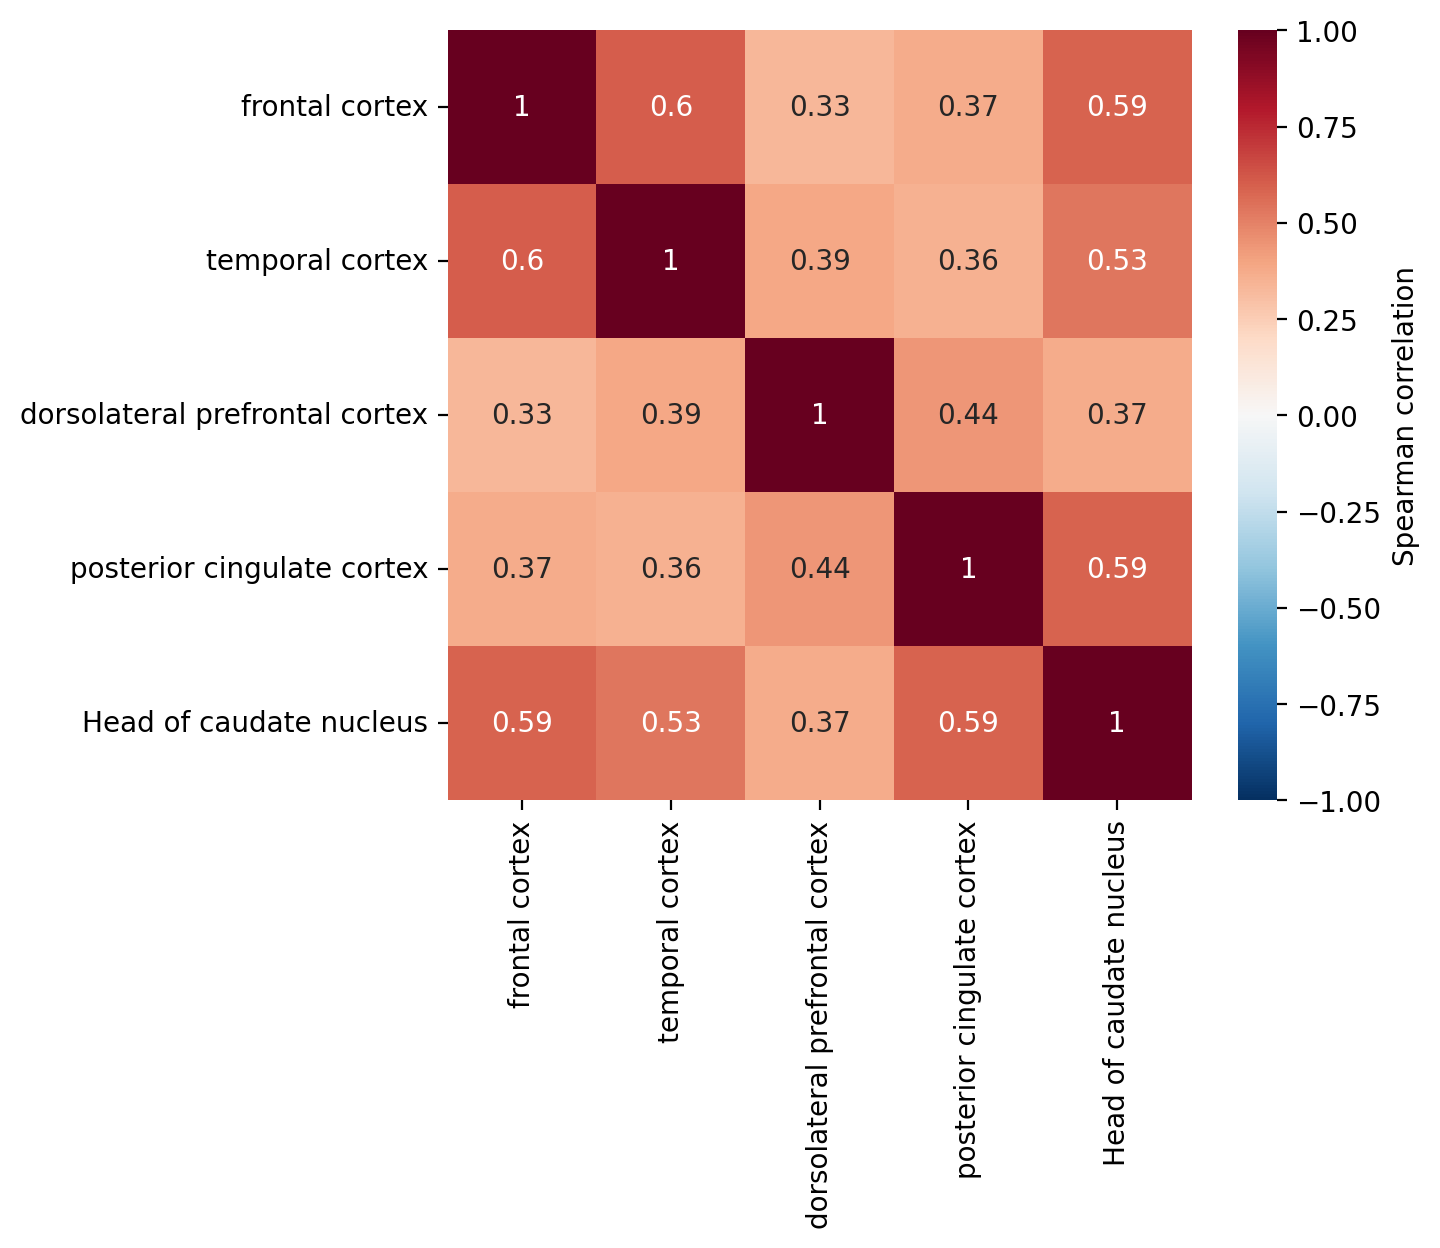

In [ ]:
tissue_dfs = {}
for tissue in harmonization.dream_expression['tissue'].unique():
    tissue_df = harmonization.dream_expression.query(f"tissue == '{tissue}' and exclude != True")[['DREAM_normalized_enrichment_score_resid', 'individualID']]
    tissue_df.rename(columns = {'DREAM_normalized_enrichment_score_resid': f'{tissue}_DREAM_normalized_enrichment_score_resid'}, inplace = True)
    tissue_dfs[tissue] = tissue_df
# merge tissue dfs on individualID
merged_df = tissue_dfs['frontal cortex'].merge(tissue_dfs['temporal cortex'], on = 'individualID', how = 'outer').merge(tissue_dfs['dorsolateral prefrontal cortex'], on = 'individualID', how = 'outer').merge(tissue_dfs['posterior cingulate cortex'], on = 'individualID', how = 'outer').merge(tissue_dfs['Head of caudate nucleus'], on = 'individualID', how = 'outer')
merged_df.set_index('individualID', inplace = True)

corr_df = merged_df.corr(method = 'spearman')
# split row and column names on _DREAM_normalized_enrichment_score_resid and take the first part
corr_df.index = corr_df.index.str.split('_DREAM_normalized_enrichment_score_resid').str[0]
corr_df.columns = corr_df.columns.str.split('_DREAM_normalized_enrichment_score_resid').str[0]

fig, ax = plt.subplots(1, 1, figsize = (6, 5))
sns.heatmap(
    corr_df, annot = True, cmap = 'RdBu_r',
    vmin = -1, vmax = 1, center = 0, cbar_kws = {'label': 'Spearman correlation'},
    ax = ax
)
# to get pvalues
for tissue in merged_df.columns:
    for other_tissue in merged_df.columns:
        if tissue != other_tissue:
            print(tissue, other_tissue, spearmanr(merged_df.dropna(subset = [tissue, other_tissue])[tissue], merged_df.dropna(subset = [tissue, other_tissue])[other_tissue]).pvalue)
            
fig.savefig(os.path.join(REPO_ROOT, 'figures/supplementary/human_mut/corr_across_brain_regions.svg'), bbox_inches = 'tight')

In [13]:
harmonization.dream_expression.groupby('individualID')['tissue'].nunique().describe()

count    1168.000000
mean        2.382705
std         0.991796
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: tissue, dtype: float64

In [10]:
# count number of non-nan entries in merged_df
print(f"number of non-nan entries: {merged_df.notna().sum().sum()}")
print(f"total number of entries: {merged_df.size}")
print(f"percent non-nan: {(merged_df.notna().sum().sum() / merged_df.size * 100):.1f}%")


number of non-nan entries: 2776
total number of entries: 5835
percent non-nan: 47.6%


### reverse causation

0 (1 - 5] 0.37843322059664786
0 (0 - 1] 0.1869192439057904
0 (5 - 10] 0.9777053498374919
0 (10 - 15] 0.12532754929660897
(1 - 5] (0 - 1] 0.5037553708097009
(1 - 5] (5 - 10] 0.7149671143364091
(1 - 5] (10 - 15] 0.21617660584227705
(0 - 1] (5 - 10] 0.5340729087572686
(0 - 1] (10 - 15] 0.36043076653475636
(5 - 10] (10 - 15] 0.2380407304342469


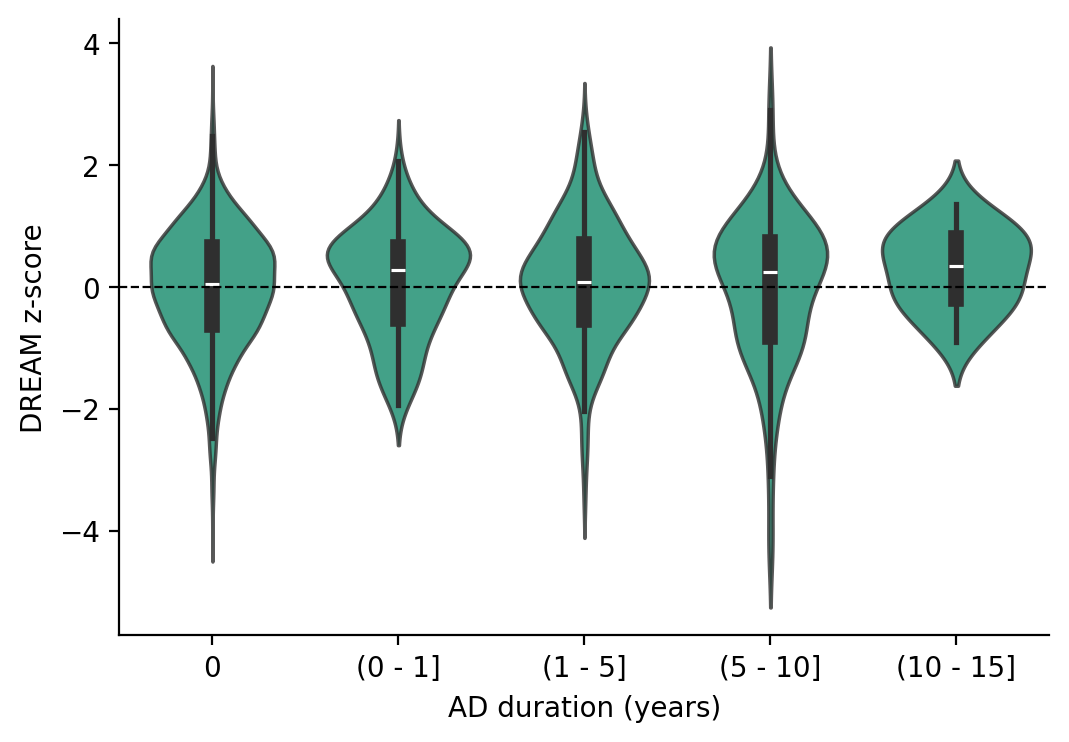

In [44]:
survival_df_harmonization['ad_duration'] = survival_df_harmonization['age_death'] - survival_df_harmonization['age_diagnosis']
# bin ad duration
survival_df_harmonization['ad_duration_bin'] = pd.cut(survival_df_harmonization['ad_duration'], bins = [-1, 0, 1, 5, 10, 15], labels = ['0', '(0 - 1]', '(1 - 5]', '(5 - 10]', '(10 - 15]'])

fig, axes = plt.subplots(figsize = (6, 4))
sns.violinplot(
    x = 'ad_duration_bin', y = 'z_DREAM_normalized_enrichment_score_resid', 
    data = survival_df_harmonization.query("exclude != True and z_DREAM_normalized_enrichment_score_resid < 5 and z_DREAM_normalized_enrichment_score_resid > -5"),
    ax = axes, color = my_categorical_palette[0], alpha = 0.8
    )
axes.set_xlabel('AD duration (years)')
axes.set_ylabel(f'{dream_col}')
# dashed line at 0
axes.axhline(0, color = 'black', linestyle = '--', linewidth = 0.8)
sns.despine(ax = axes)

# do a mann whitney u test between each bin, all combinations
from itertools import combinations
for bin1, bin2 in combinations(survival_df_harmonization['ad_duration_bin'].unique(), 2):
    print(bin1, bin2, mannwhitneyu(survival_df_harmonization.query(f"ad_duration_bin == '{bin1}'")['z_DREAM_normalized_enrichment_score_resid'], survival_df_harmonization.query(f"ad_duration_bin == '{bin2}'")['z_DREAM_normalized_enrichment_score_resid']).pvalue)
    
fig.savefig(os.path.join(REPO_ROOT, 'figures/supplementary/human_mut/ad_duration_reverse_causation_violin.svg'), bbox_inches = 'tight')